In [2]:
import os
import numpy as np
import pandas as pd
import math
import matplotlib.pylab as plt
import seaborn as sns

%matplotlib inline
sns.set(style='ticks', palette='Set2')

In [56]:
# Load data
df = pd.read_excel('Customer_Churn.xlsx').dropna()

# Transform category variables into values:

    # COLLEGE = 0 if no, 1 if yes
df['COLLEGE'].replace(['zero','one'], 
                      [0,1], inplace=True)

    # REPORTED_SATISFACTION on a standard 1 = low, 5 = high scale
df['REPORTED_SATISFACTION'].replace(['very_unsat','unsat','avg','sat','very_sat'],
                                    [1,2,3,4,5], inplace=True)

    # REPORTED_USAGE_LEVEL on a standard 1 = low, 5 = high scale
df['REPORTED_USAGE_LEVEL'].replace(['very_little','little','avg','high','very_high'],
                                   [1,2,3,4,5], inplace=True)

    # CONSIDERING_CHANGE_OF_PLAN on a standard 1 = unlikely, 5 = likely scale
df['CONSIDERING_CHANGE_OF_PLAN'].replace(['never_thought','no','perhaps','considering','actively_looking_into_it'],
                                         [1,2,3,4,5], inplace=True)

#df['LEAVE'].replace(['STAY','LEAVE'], [0,1], inplace=True)

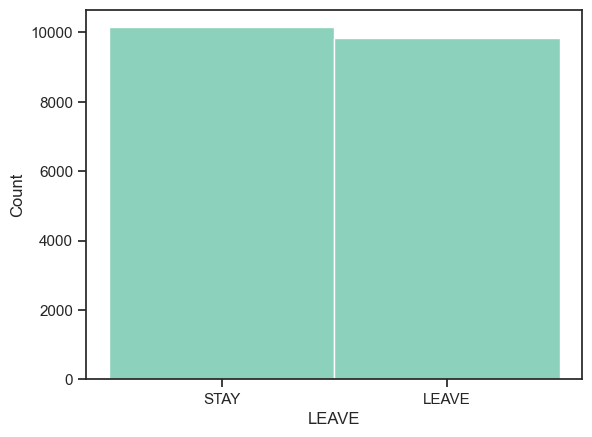

In [59]:
sns.histplot(data=df, x=df['LEAVE'])
plt.show()

In [ ]:
sns.boxplot(data=df, x='LEAVE', y='REPORTED_SATISFACTION', width=0.45)
plt.show()
# This was not helpful; there is no visible difference

In [ ]:
for r in range(2):
    hist = df[df.LEAVE == r].hist('INCOME')
    plt.title('Income where LEAVE =' + str(r))
    plt.show()

# Better visualization of the differences between distributions

In [ ]:
sns.boxplot(data=df, x='CONSIDERING_CHANGE_OF_PLAN', y='LEAVE', width=0.45)
plt.show()
# Same as above

In [ ]:
for r in range(2):
    hist = df[df.LEAVE == r].hist('OVERAGE')
    plt.title('Overages where LEAVE =' + str(r))
    plt.show()

# Better visualization of the differences between distributions

In [ ]:
#Create a plot to see data alongside each other. This has an error I haven't resolved because I don't fully understand what it's doing.

# Column names
categorical_cols = ['COLLEGE','REPORTED_SATISFACTION','REPORTED_USAGE_LEVEL','CONSIDERING_CHANGE_OF_PLAN']
continuous_cols = ['INCOME','OVERAGE','LEFTOVER','HOUSE','HANDSET_PRICE','OVER_15MINS_CALLS_PER_MONTH','AVERAGE_CALL_DURATION']
target_col = 'LEAVE'
predictor_cols = categorical_cols + continuous_cols

rows = 2
fig, axs = plt.subplots(ncols=cols, nrows=rows, figsize=(7*cols, 7*rows))
axs = axs.flatten()
posn = 0

# Plot continuous features
for col in continuous_cols:
    sns.boxplot(data=df, x=target_col, y=col, ax=axs[posn])
    axs[posn].set_ylabel(col)
    axs[posn].set_title('')
    posn+=1

In [60]:
from sklearn.tree import DecisionTreeClassifier

predictor_cols = ['COLLEGE','REPORTED_SATISFACTION','REPORTED_USAGE_LEVEL','CONSIDERING_CHANGE_OF_PLAN',
                  'INCOME','OVERAGE','LEFTOVER','HOUSE','HANDSET_PRICE','OVER_15MINS_CALLS_PER_MONTH','AVERAGE_CALL_DURATION']
decision_tree = DecisionTreeClassifier(criterion='entropy', max_depth=7)
decision_tree.fit(df[predictor_cols],df['LEAVE'])

DecisionTreeClassifier(criterion='entropy', max_depth=7)

In [ ]:
# Attempting to create the visualization using the code she gave us. Didn't succeed.

from IPython.display import Image
from sklearn.tree import export_graphviz

def visualize_tree(decision_tree, feature_names, class_names, directory='MacHD/Users/james/TIM147/Personal', name='tree',proportion=True):
    # Export to graphviz format
    dot_name = '%s/%s.png' % (directory, name)
    dot_file = export_graphviz(decision_tree, out_file=dot_name,
                               feature_names=feature_names, class_names=class_names, proportion=proportion)
    # Make image file from decision tree
    image_name = '%s.%s.png' % (directory, name)
    os.system('dot -T png %s -o %s' % (dot_name, image_name))
    # Return .png
    return Image(filename=image_name)

visualize_tree(decision_tree, predictor_cols, df['LEAVE'])

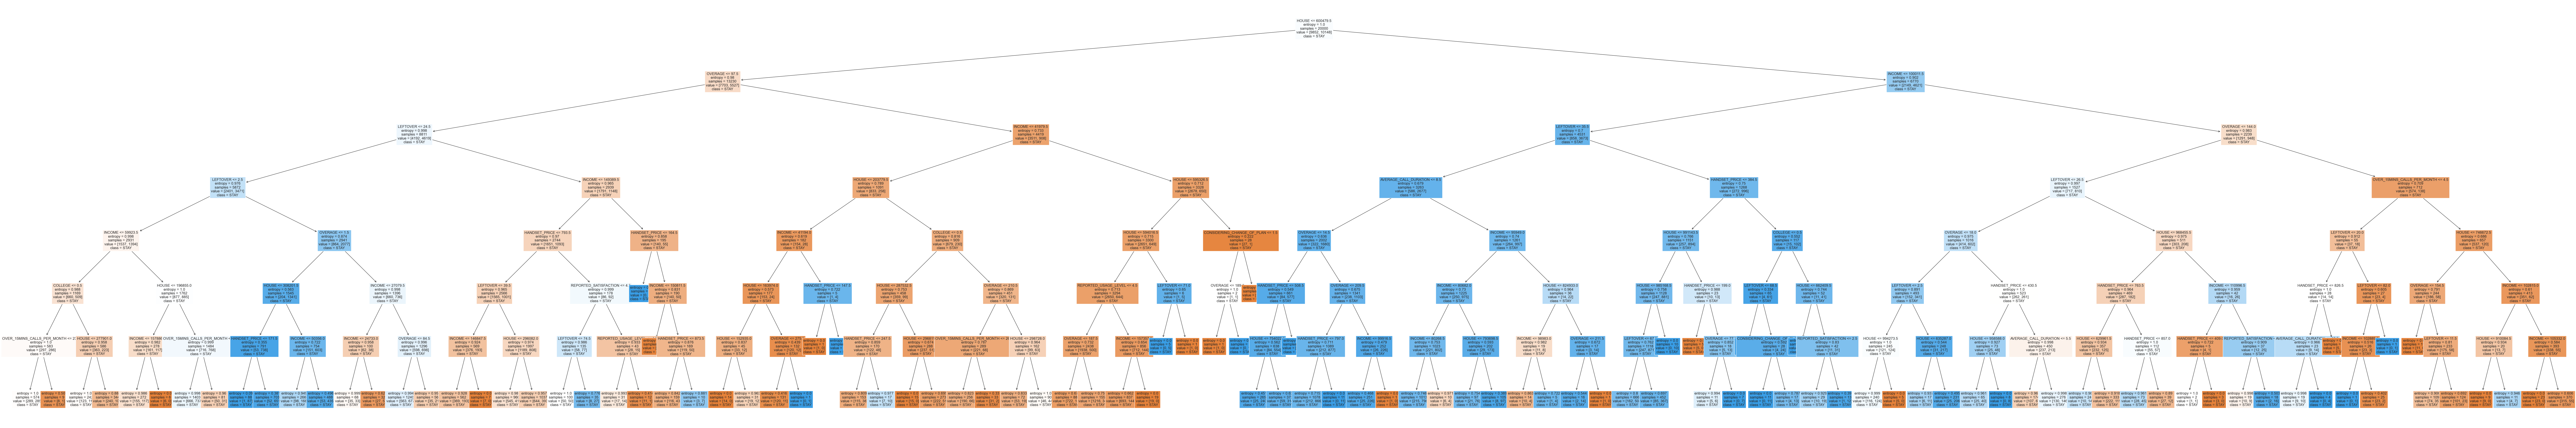

In [62]:
from sklearn import tree

fig = plt.figure(figsize=(150,25))
_=tree.plot_tree(decision_tree, feature_names=predictor_cols, class_names=df['LEAVE'].astype('str'), filled=True, fontsize=12)
fig.savefig('decision_tree.png')

# A tree with entropy as its metric is always predicting class = "STAY' even though it's balanced data